In [1]:
from typing import Any
from pathlib import Path
import json

import polars as pl
from pydantic import BaseModel

IMG = "img"
NAME = "name"
KP_1 = "kp-1"

path_data = Path("data")
path_captures = path_data / "captures"
path_labels = path_data / "labels.csv"

# Solo agarro las columnas que necesito.
_COLS_TO_KEEP = [IMG, KP_1]
df = pl.read_csv(path_labels, columns=_COLS_TO_KEEP)

# Le saco el path agregado por label-studio.
df.insert_column(0, pl.Series(NAME, [img.split("-")[-1] for img in df[IMG]]))
df

name,img,kp-1
str,str,str
"""001.jpg""","""/data/upload/2/ff2f8f9b-001.jp…","""[{""x"":66.74496644295303,""y"":15…"
"""002.jpg""","""/data/upload/2/aba1de35-002.jp…","""[{""x"":66.44295302013423,""y"":15…"
"""003.jpg""","""/data/upload/2/217e3997-003.jp…","""[{""x"":66.54362416107384,""y"":15…"
"""004.jpg""","""/data/upload/2/92b8136a-004.jp…","""[{""x"":66.44295302013423,""y"":15…"
"""005.jpg""","""/data/upload/2/c3cded86-005.jp…","""[{""x"":66.64429530201342,""y"":15…"
…,…,…
"""007.jpg""","""/data/upload/2/4f3712b5-007.jp…","""[{""x"":66.24161073825505,""y"":15…"
"""008.jpg""","""/data/upload/2/f1bad2a4-008.jp…","""[{""x"":66.54362416107384,""y"":15…"
"""009.jpg""","""/data/upload/2/90451b5a-009.jp…","""[{""x"":49.0268456375839,""y"":60.…"


In [2]:
from typing import Dict, List, Literal

from pydantic import Field
import numpy as np

class Label(BaseModel):
    x: float
    y: float
    keypointlabels: Literal["foot", "reference"]
    original_width: float
    original_height: float


class LabelPoints(BaseModel):
    foot: List[Label] = Field(default_factory=list)
    reference: List[Label] = Field(default_factory=list)

    @property
    def foot_array(self) -> np.ndarray:
        return np.array([[f.x, f.y] for f in self.foot], dtype=np.float32)

    @property
    def reference_array(self) -> np.ndarray:
        return np.array([[r.x, r.y] for r in self.reference], dtype=np.float32)



In [3]:
name2label: Dict[str, LabelPoints] = {}
for row in df.iter_rows(named=True):
    name = row[NAME]
    for label in json.loads(row[KP_1]):
        label["keypointlabels"] = label["keypointlabels"][0]
        label = Label(**label)
        if name not in name2label:
            name2label[name] = LabelPoints()
        
        if label.keypointlabels == "foot":
            name2label[name].foot.append(label)
        elif label.keypointlabels == "reference":
            name2label[name].reference.append(label)
        else:
            raise NotImplementedError("Implement.")

In [4]:
IMG_NAME = "004.jpg"
display(name2label[IMG_NAME].foot)
display(name2label[IMG_NAME].reference)

[Label(x=50.33557046979866, y=67.38255033557047, keypointlabels='foot', original_width=640.0, original_height=480.0),
 Label(x=61.10738255033558, y=84.02684563758389, keypointlabels='foot', original_width=640.0, original_height=480.0),
 Label(x=64.63087248322148, y=32.48322147651007, keypointlabels='foot', original_width=640.0, original_height=480.0)]

[Label(x=66.44295302013423, y=15.167785234899329, keypointlabels='reference', original_width=640.0, original_height=480.0),
 Label(x=42.08053691275168, y=41.74496644295302, keypointlabels='reference', original_width=640.0, original_height=480.0),
 Label(x=21.140939597315437, y=45.63758389261745, keypointlabels='reference', original_width=640.0, original_height=480.0),
 Label(x=49.32885906040269, y=61.34228187919463, keypointlabels='reference', original_width=640.0, original_height=480.0)]

In [5]:
import cv2
import numpy as np

# Coordenadas en la imagen (x, y) de puntos de referencia.
#points_ref = name2label[IMG_NAME].reference_array
points_ref = np.array([     # FIXME: Hardcodeo por que al labelear no tuve en cuenta el orden de los puntos.
    [66, 15],
    [21, 45],
    [42, 41],
    [59, 60]
], dtype=np.float32)

# TODO: Ver si es esto.
#IMG_HEIGHT = name2label[IMG_NAME].reference[0].original_height
# Invertimos Y en puntos de imagen
#points_ref_flipped = points_ref.copy()
#points_ref_flipped[:, 1] = IMG_HEIGHT - points_ref_flipped[:, 1]
# TODO: Ver si es esto.

# Coordenadas conocidas en el plano real (por ejemplo, en metros o pixeles del mapa).
#points_labeled = name2label["001.jpg"].foot_array
points_real = np.array([
    [275, 375],
    [62.5, 273],
    [126.5, 273],
    [126.5, 213]
], dtype=np.float32)

room_outline = np.array([
    [0, 375+33.5+50],
    [0, 375+33.5],
    [195, 375+33.5],
    [195, 375],
    [0, 375],
    [0, 0],
    [293, 0],
    [293, 375],
    [293-18, 375],
    [293-18, 375+33.5],
    [293+18.5, 375+33.5],
    [293+18.5, 375+33.5+50]
], dtype=np.float32)

# Calcula la matriz de homografía.
H, _ = cv2.findHomography(points_ref, points_real)



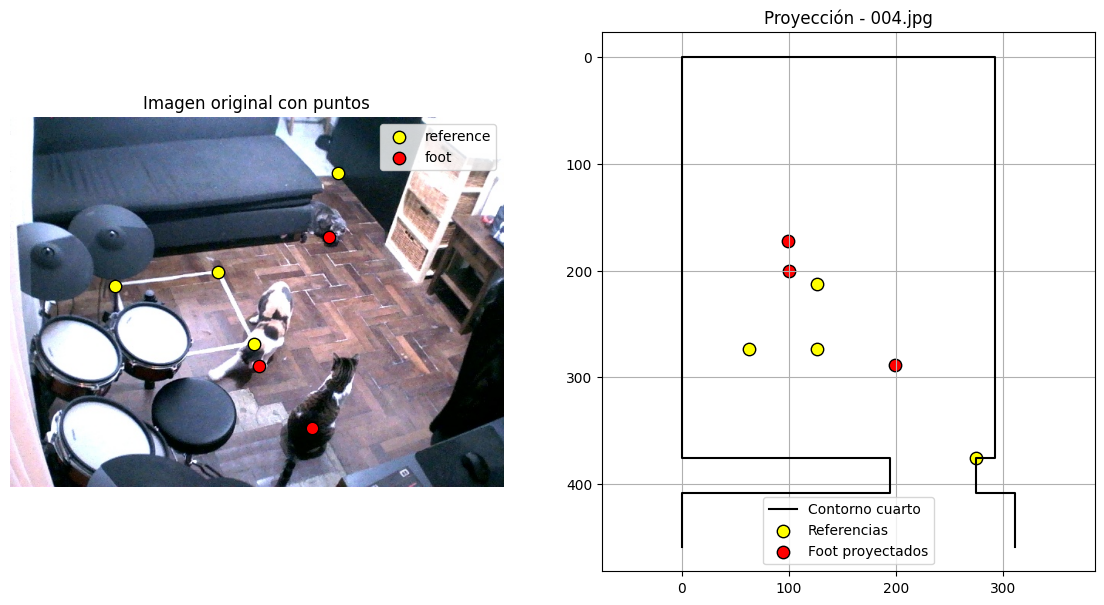

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path

def project_points(image_points: np.ndarray, H: np.ndarray) -> np.ndarray:
    """ Proyecta puntos desde la imagen al plano real usando la homografía. """
    pts = image_points.reshape(-1, 1, 2).astype(np.float32)
    projected = cv2.perspectiveTransform(pts, H)
    return projected.reshape(-1, 2)

def show_image_with_points(
    img_path: Path,
    foot_pts: np.ndarray,
    ref_pts: np.ndarray,
    original_width: float,
    original_height: float
) -> np.ndarray:
    """ Carga y muestra la imagen con puntos sobrepuestos. """
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(14, 7))

    axs[0].imshow(img)
    axs[0].scatter(ref_pts[:, 0]*(original_width/100), ref_pts[:, 1]*(original_height/100), c='yellow', label='reference', s=80, edgecolor='black')
    axs[0].scatter(foot_pts[:, 0]*(original_width/100), foot_pts[:, 1]*(original_height/100), c='red', label='foot', s=80, edgecolor='black')
    axs[0].axis('off')
    axs[0].legend()
    axs[0].set_title("Imagen original con puntos")

    return axs[1]  # Devuelve el segundo eje para graficar el plano

def plot_projection_on_axes(
    ax: plt.Axes,
    room_contour: np.ndarray,
    reference_pts: np.ndarray,
    projected_pts: np.ndarray,
    img_name: str
) -> None:
    """ Dibuja el plano del cuarto en un subplot existente. """
    ax.plot(room_contour[:, 0], room_contour[:, 1], 'k-', label='Contorno cuarto')
    ax.scatter(reference_pts[:, 0], reference_pts[:, 1], c='yellow', label='Referencias', s=80, edgecolor='black')
    ax.scatter(projected_pts[:, 0], projected_pts[:, 1], c='red', label='Foot proyectados', s=80, edgecolor='black')
    ax.set_title(f"Proyección - {img_name}")
    ax.axis('equal')
    ax.invert_yaxis()
    ax.grid(True)
    ax.legend()



IMG_PATH = path_captures / IMG_NAME
foot_img_pts = name2label[IMG_NAME].foot_array
ref_img_pts = name2label[IMG_NAME].reference_array
original_width = name2label[IMG_NAME].reference[0].original_width
original_height = name2label[IMG_NAME].reference[0].original_height

foot_projected = project_points(foot_img_pts, H)

ax_right = show_image_with_points(IMG_PATH, foot_img_pts, ref_img_pts, original_width, original_height)
plot_projection_on_axes(ax_right, room_outline, points_real, foot_projected, IMG_NAME)

plt.show()
